In [1]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [58]:
ref_pred = ref_provider.get_pred(200,  ref_provider.train_representation(200))
clean_pred = clean_provider.get_pred(200,  clean_provider.train_representation(200))
ref_pred = ref_pred.argmax(axis=1)
clean_pred = clean_pred.argmax(axis=1)
diff_list = []
for i in range(len(ref_pred)):
    if ref_pred[i] != clean_pred[i]:
        diff_list.append(i)
print(len(diff_list))
for k in range(len(diff_list)):
    index = diff_list[k]
    print("index", index, 'ref label',ref_provider.train_labels(200)[index],'ref_pred:',ref_pred[index], 'clean label',clean_provider.train_labels(200)[index],'clean_pred:',clean_pred[index])

100%|██████████| 250/250 [00:00<00:00, 9347.35it/s]


71
index 619 ref label 7 ref_pred: 7 clean label 6 clean_pred: 6
index 973 ref label 8 ref_pred: 8 clean label 7 clean_pred: 7
index 1316 ref label 3 ref_pred: 5 clean label 3 clean_pred: 3
index 2747 ref label 6 ref_pred: 6 clean label 5 clean_pred: 5
index 2833 ref label 3 ref_pred: 3 clean label 2 clean_pred: 2
index 3359 ref label 9 ref_pred: 9 clean label 8 clean_pred: 8
index 5077 ref label 0 ref_pred: 0 clean label 9 clean_pred: 9
index 5645 ref label 5 ref_pred: 0 clean label 5 clean_pred: 2
index 7508 ref label 9 ref_pred: 9 clean label 8 clean_pred: 8
index 7810 ref label 1 ref_pred: 1 clean label 0 clean_pred: 0
index 8157 ref label 3 ref_pred: 3 clean label 2 clean_pred: 2
index 8259 ref label 3 ref_pred: 6 clean label 3 clean_pred: 3
index 9132 ref label 5 ref_pred: 5 clean label 5 clean_pred: 3
index 9316 ref label 5 ref_pred: 3 clean label 5 clean_pred: 5
index 9745 ref label 2 ref_pred: 2 clean label 1 clean_pred: 1
index 10584 ref label 7 ref_pred: 5 clean label 7 clea

In [18]:
 from pynndescent import NNDescent
 from sklearn.utils import check_random_state
 from umap.umap_ import fuzzy_simplicial_set

 def _construct_fuzzy_complex(n_neighbors, train_data):
        """
        construct a vietoris-rips complex
        """
        # number of trees in random projection forest
        n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
        # max number of nearest neighbor iters to perform
        n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
        # distance metric
        metric = "euclidean"
        # get nearest neighbors
        nnd = NNDescent(
            train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            n_trees=n_trees,
            n_iters=n_iters,
            max_candidates=60,
            verbose=True
        )
        knn_indices, knn_dists = nnd.neighbor_graph
        random_state = check_random_state(None)
        complex, sigmas, rhos = fuzzy_simplicial_set(
            X=train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            random_state=random_state,
            knn_indices=knn_indices,
            knn_dists=knn_dists,
        )
        return complex, sigmas, rhos, knn_indices
tar_complex, tar_sigmas, tar_rhos, tar_knn_indices = _construct_fuzzy_complex(2, ref_provider.train_representation(200))
ref_complex, ref_sigmas, ref_rhos, ref_knn_indices = _construct_fuzzy_complex(2, clean_provider.train_representation(200))

Sat Dec 31 00:31:04 2022 Building RP forest with 16 trees
Sat Dec 31 00:31:04 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Dec 31 00:31:05 2022 Building RP forest with 16 trees
Sat Dec 31 00:31:05 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [51]:
tar_knn_indices[8259]

array([ 8259, 26135], dtype=int32)

In [64]:
diff_list =[8259, 13247,26135]

In [33]:
import json
newtrain = clean_provider.train_representation(200)
for k in range(len(diff_list)):
    index = diff_list[k]
    nearest_index_in_tar = tar_knn_indices[index][1]
    # print(index,nearest_index_in_tar)
    newtrain[index] = clean_provider.train_representation(200)[nearest_index_in_tar]
 
    # print('index',index, 'tar',tar_knn_indices[index],'ref', ref_knn_indices[index])
filename = now = time.strftime("clean_as_ref_epoch_200.json", time.localtime(time.time())) 
rlist = json.dumps(newtrain.tolist())
with open(filename, 'w', encoding='utf-8') as file_obj:

    file_obj.write(rlist)




Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9662.25it/s]


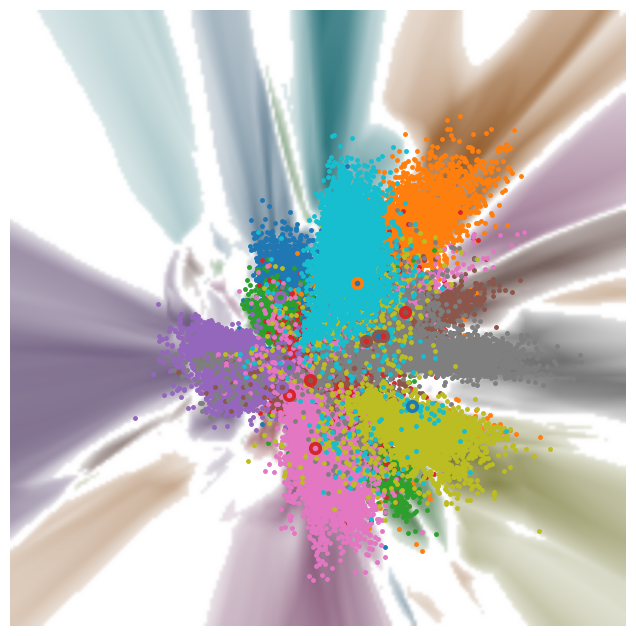

In [61]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT,I, np.dot(ref_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]


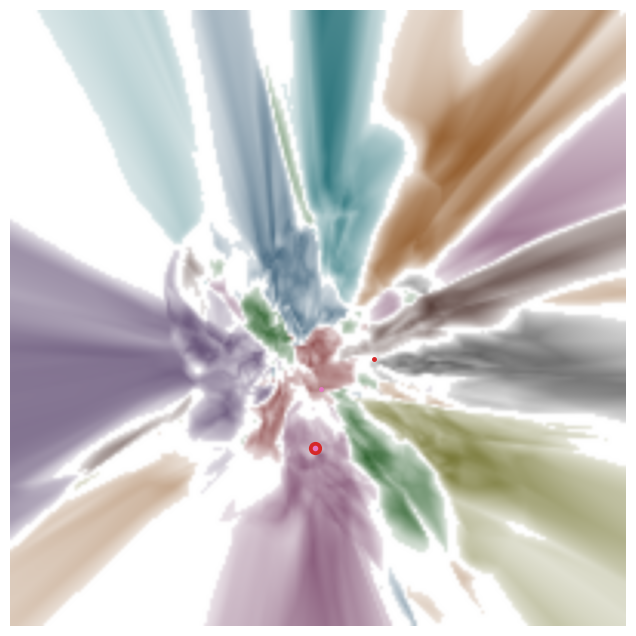

In [66]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT,I, np.dot(ref_provider.train_representation(200),R), projector, 200,diff_list,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9348.18it/s]


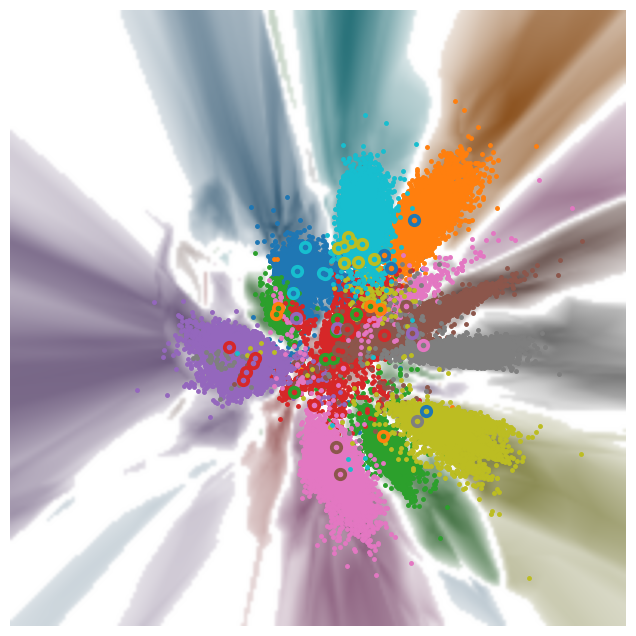

In [63]:
with open('clean_as_ref_epoch_200.json', 'r', encoding='utf-8') as file_obj:
    A = json.load(file_obj)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_provider, np.array(A), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9334.53it/s]


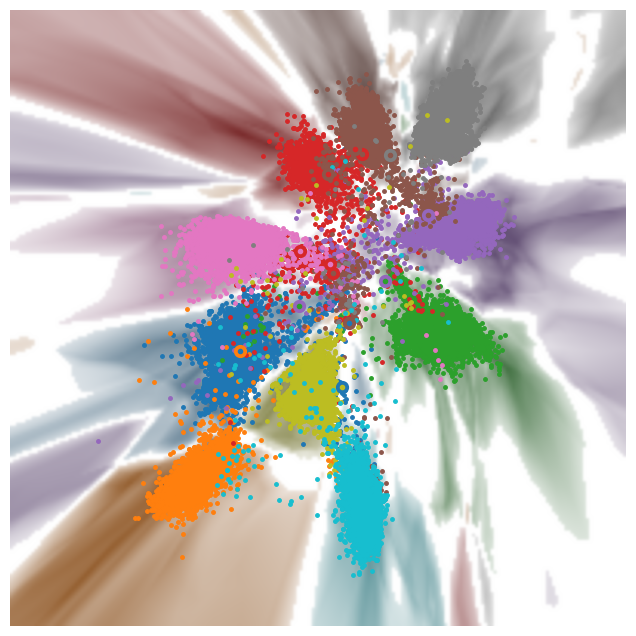

In [62]:
with open('clean_as_ref_epoch_200.json', 'r', encoding='utf-8') as file_obj:
    A = json.load(file_obj)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_provider.train_representation(200), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))